In [84]:
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
df = pd.read_csv('Charging details report October 10, 2014 - October 21, 2022.csv', delimiter=';')

In [86]:
df.head()

,ChargeStartDateTime,Model,Country,SiteLocationName,Description,QuantityBase,QuantityTier1,QuantityTier2,QuantityTier3,QuantityTier4,...,UnitCostBase,UnitCostTier1,UnitCostTier2,UnitCostTier3,UnitCostTier4,VAT,Total Exc. VAT,Total Inc. VAT,Status,Invoice
0,2022-10-21T08:45:10+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,34.00 kwh,NaN,NaN,NaN,NaN,...,2.60/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
1,2022-10-04T16:04:27+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,24.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
2,2022-10-04T15:52:52+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,9.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
3,2022-10-01T13:55:09+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,31.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
4,2022-09-27T14:49:04+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,41.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN


In [87]:
df['QuantityBase'] = df['QuantityBase'].str.replace(' kwh', '').astype(float)
df['ChargeStartDateTime'] = pd.to_datetime(df['ChargeStartDateTime'], utc=True)
df['year'] = df.ChargeStartDateTime.dt.year
df['ChargeStartDateTime'] = df['ChargeStartDateTime'].dt.date
import datetime
df = df[(df['ChargeStartDateTime']>datetime.date(2019,1,11))]

from convert_country_codes import convert_ISO_3166_2_to_1
df['iso_a3'] = df['Country'].map(convert_ISO_3166_2_to_1)

df[['City', 'Country']] = df.SiteLocationName.str.split(',', expand=True)
df[['Country', '_']] = df['Country'].str.strip().str.split(' ', n=1, expand=True)
mean_value=df['QuantityBase'].mean()
df['QuantityBase'].fillna(value=mean_value, inplace=True)

df['Energy'] = df.QuantityBase

df = df[['ChargeStartDateTime', 'Energy', 'UnitCostBase', 'Country', 'year', 'City', 'iso_a3']]

In [88]:
df.head()

,ChargeStartDateTime,Energy,UnitCostBase,Country,year,City,iso_a3
0,2022-10-21,34.0,2.60/kwh,Poland,2022,Krakow,POL
1,2022-10-04,24.0,2.65/kwh,Poland,2022,Krakow,POL
2,2022-10-04,9.0,2.65/kwh,Poland,2022,Krakow,POL
3,2022-10-01,31.0,2.65/kwh,Poland,2022,Krakow,POL
4,2022-09-27,41.0,2.65/kwh,Poland,2022,Krakow,POL


# TESLA MODEL S 85 CHARGING DATA FROM 2017/03/31 TO 2022/11/11

## GENERAL STATISTICS

### TOTAL ENERGY (kwh)

In [ ]:
df['Energy'].sum()

10350.225941422594

### MEAN CHARGING

In [ ]:
df['Energy'].mean()

33.82426778242678

### MEAN DISTANCE BETWEEN CHARGING (MEAN ENERGY CONSUMPTION = 0.2 kwh/km)

In [ ]:
mean_energy_consumption = 0.2
df['Energy'].mean() / mean_energy_consumption

169.1213389121339

### TOTAL COST OF ENERGY (PLN)

In [ ]:
price_kwh_pln = 2.5
df['Energy'].sum() * price_kwh_pln

25875.564853556483

## STATISTICS BY YEAR

### CHARGED ENERGY BY YEAR

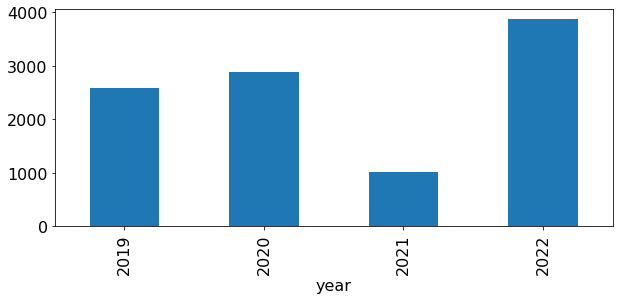

In [ ]:
plt.rcParams['figure.figsize']=(10,4)
plt.rcParams['font.size']=16
df.groupby('year').sum()['Energy'].plot.bar()
plt.show()

### CHARGE COUNT BY YEAR

## CHARGED ENERGY BY COUNTRY

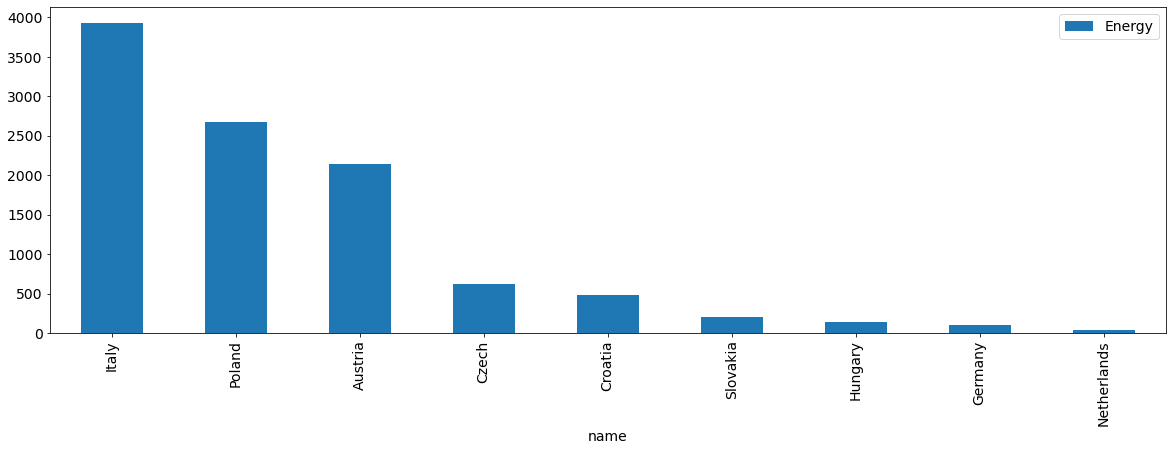

In [ ]:
df_energy_country = pd.DataFrame(df.groupby('name').sum()['Energy']).sort_values(by='Energy', ascending=False)
# fig = plt.Figure(figsize=(20, 20))
plt.rcParams['figure.figsize']=(20,6)
plt.rcParams['font.size']=14
df_energy_country.plot.bar()
plt.show()

In [90]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action='ignore')

In [91]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

europe=world[world.continent=='Europe']
europe=europe[(europe.name!='Russia') & (europe.name!='Iceland')]
# Create a custom polygon
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
europe=geopandas.clip(europe, polygon) 

df_country = pd.DataFrame(df.groupby('iso_a3').sum()).reset_index()
df_country

selected_countries=europe[europe.iso_a3.isin(list(df_country.iso_a3))]
selected_countries=selected_countries.merge(df_country, on='iso_a3',how='left')


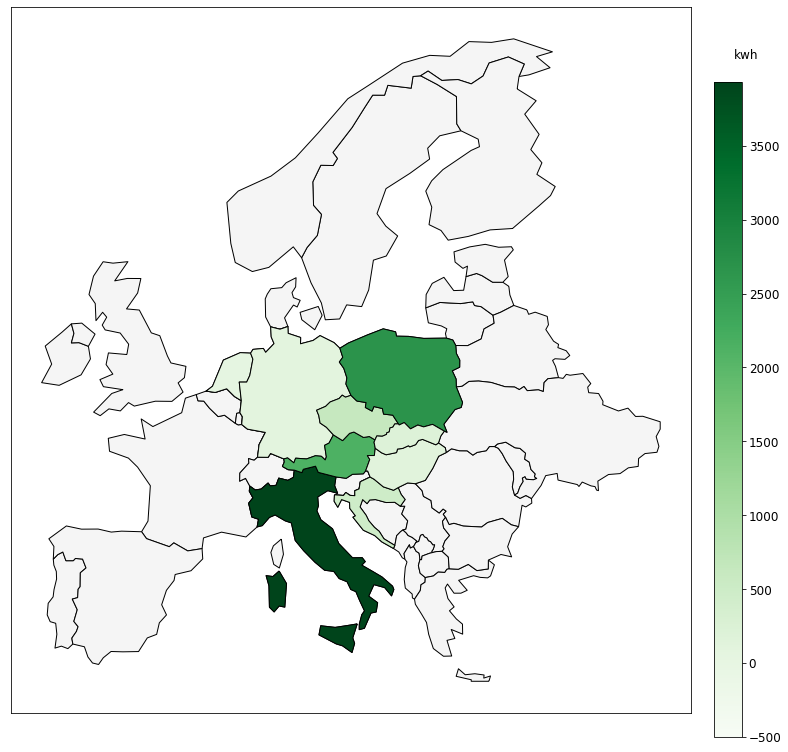

In [92]:
plt.rcParams['figure.figsize']=(13,13)
plt.rcParams['font.size']=12

fig,ax=plt.subplots()

vmin = df_country['Energy'].min()
vmin = -500
vmax = df_country['Energy'].max()

ax = europe.plot(color='whitesmoke',edgecolor='black', ax=ax)
selected_countries.plot('Energy',cmap='Greens', edgecolor='black', ax=ax, vmin=vmin, vmax=vmax)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

# add colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.7]) #[left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable.
sm._A = []
lgd=fig.colorbar(sm, cax=cax).set_label('kwh', rotation=0, y=1.05, labelpad=-35)
plt.show()

## CHARGED ENERGY BY SUPERCHARGER LOCATION  -> CITY